In [2]:
from wedgescan_functions import get_slice_processed
from cil.framework import ImageGeometry
from cil.utilities.display import show2D
from cil.processors import RingRemover, Padder, Slicer
from cil.recon import FBP

import numpy as np

import matplotlib.pyplot as plt
from cil.plugins.tigre import ProjectionOperator

In [3]:
data_slice = get_slice_processed(400)

/mnt/data/ESRF/Wedgescan_Iterative_ASSB/flats.h5
	 - data : <HDF5 dataset "data": shape (60, 2160, 2560), type "<i4">
			 - interpretation : image
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/darks.h5
	 - data : <HDF5 dataset "data": shape (20, 2160, 2560), type "<i4">
			 - interpretation : image
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0000.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0001.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0002.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0003.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0004.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0005.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0006.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0007.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0008.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0009.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0010.h5
/mnt/data/ESRF/Wedgescan_Iterative_ASSB/pco2linux_0011.h5
/mnt/data/

In [4]:
data = data_slice.copy()
# process data
ig = data.geometry.get_ImageGeometry()
r = RingRemover(8,'db20', 1.5)
r.set_input(data)
data = r.get_output()
data.geometry.set_centre_of_rotation(16.5, distance_units='pixels')

Finish Ring Remover


In [5]:
# crop empty projections
data_crop = Slicer(roi={'angle': (300, 2710, 1)})(data_slice)
# process cropped data
ig = data_crop.geometry.get_ImageGeometry()
r = RingRemover(8,'db20', 1.5)
r.set_input(data_crop)
data_crop = r.get_output()
data_crop.geometry.set_centre_of_rotation(16.5, distance_units='pixels')

Finish Ring Remover


#### Find the edge of the cropped area at each horizontal row

Text(0, 0.5, 'Projections')

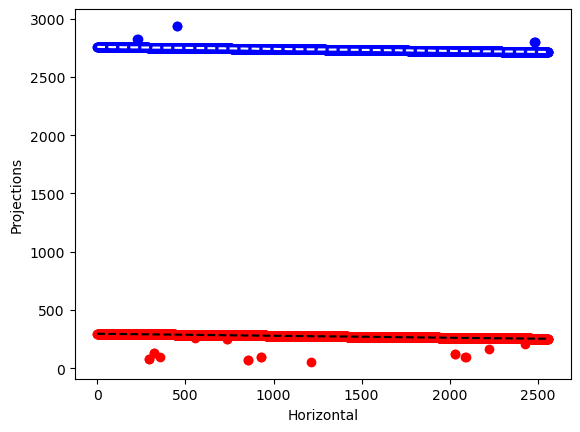

In [6]:
start_array = np.zeros(data.shape[1])
end_array = np.zeros(data.shape[1])
x = np.arange(data.shape[1])
for i in x:

    index = np.where(abs(np.diff(data.array[:,i])) > 0.75)[0]
    start_array[i] = index[0]
    end_array[i] = index[-1]

poly1d_fn = np.poly1d(np.polyfit(x,start_array,1)) 
start_fit = np.round(poly1d_fn(x)).astype(int)
plt.plot(x,start_array, 'or', x, start_fit, '--k')

poly1d_fn = np.poly1d(np.polyfit(x,end_array,1)) 
end_fit = np.round(poly1d_fn(x)).astype(int)
plt.plot(x,end_array, 'ob', x, end_fit, '--w')
plt.xlabel('Horizontal')
plt.ylabel('Projections')

#### Pad partially cropped region with local mean, then ramp to sinogram mean 

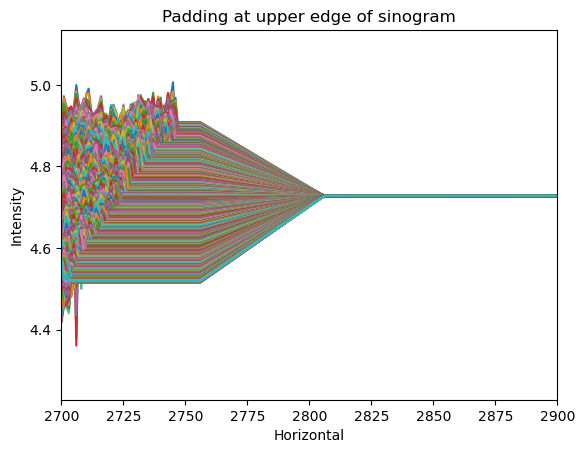

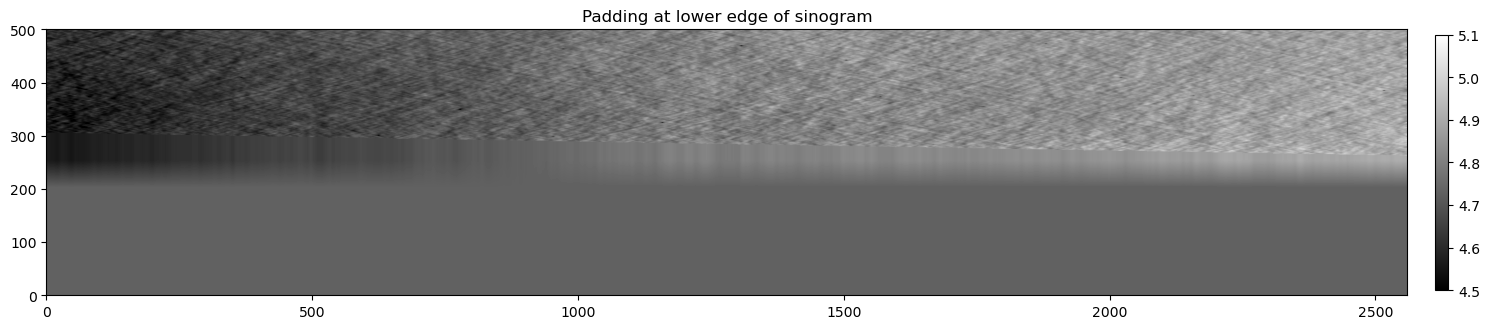

In [7]:
data_fill = data.copy()

lower_limit = np.min(start_fit)
upper_limit = np.max(end_fit)

ramp_width = 50
sino_mean = np.mean(data.array[np.max(start_fit):np.min(end_fit),i])

for i in np.arange(data.shape[1]):
# i = 1000
    start = start_fit[i]+10
    end = end_fit[i]-10

    

    data_fill.array[lower_limit:start,i] = np.mean(data_fill.array[start:start+100,i])
    y_new = np.interp(np.arange(lower_limit-ramp_width,lower_limit), [lower_limit-ramp_width,lower_limit], [sino_mean, data_fill.array[lower_limit,i]])
    data_fill.array[lower_limit-ramp_width:lower_limit,i] = y_new
    data_fill.array[0:lower_limit-ramp_width,i] = sino_mean

    data_fill.array[end:upper_limit,i] = np.mean(data_fill.array[end-100:end,i])
    y_new = np.interp(np.arange(upper_limit-1,upper_limit+ramp_width-1), [upper_limit-1, upper_limit+ramp_width-1], [data_fill.array[upper_limit-1,i], sino_mean])
    data_fill.array[upper_limit-1:upper_limit+ramp_width-1,i] = y_new
    data_fill.array[upper_limit+ramp_width-1:,i] = sino_mean
    plt.plot(data_fill.array[:,i])
    plt.xlim([2700, 2900])

plt.xlabel('Horizontal')
plt.ylabel('Intensity')
plt.title('Padding at upper edge of sinogram')

show2D(data_fill.array[0:500,:], 'Padding at lower edge of sinogram', fix_range=(4.5,5.1))

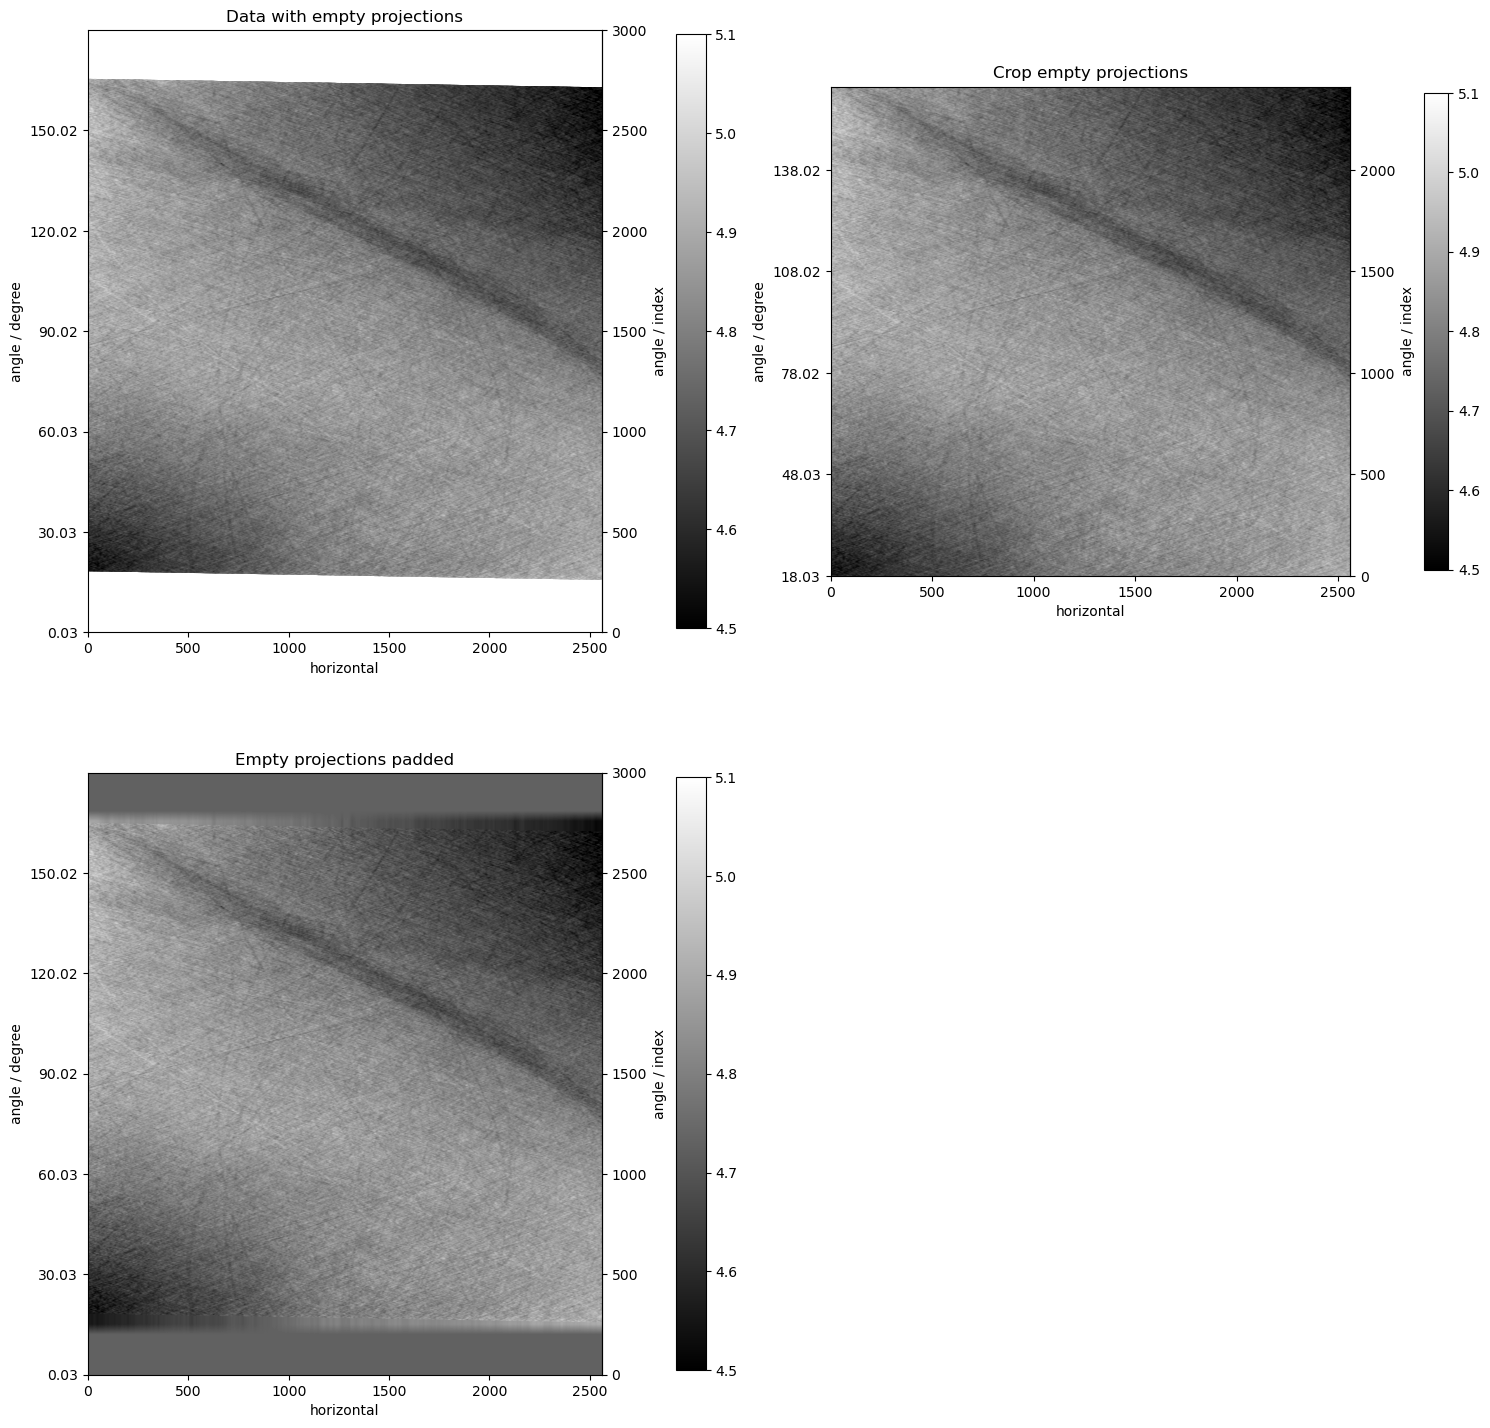

In [8]:
show2D([data, data_crop, data_fill],  ['Data with empty projections', 'Crop empty projections', 'Empty projections padded'], fix_range=(4.5, 5.1))

#### Pad horizontal

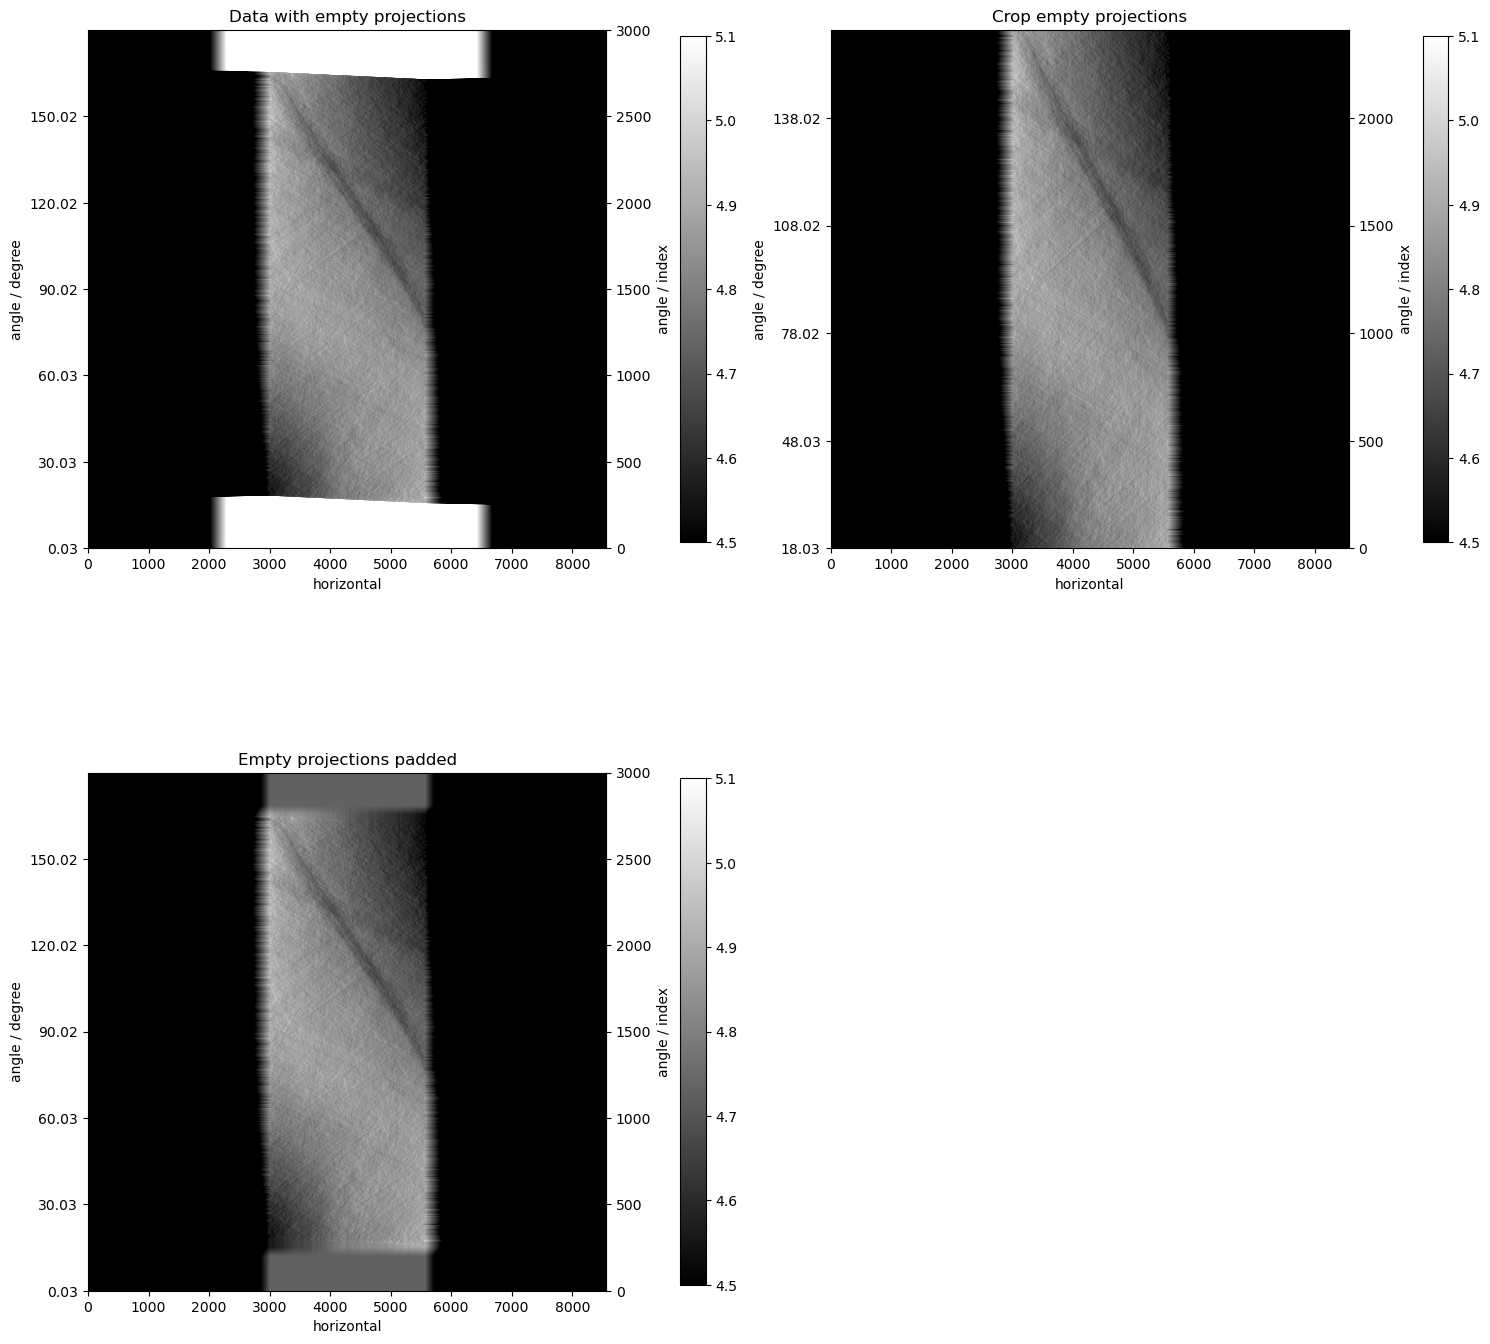

In [9]:
padsize = 3000
data_pad = Padder.linear_ramp(padsize, 0)(data)
data_crop_pad = Padder.linear_ramp(padsize, 0)(data_crop)
data_fill_pad = Padder.linear_ramp(padsize, 0)(data_fill)

show2D([data_pad, data_crop_pad, data_fill_pad], ['Data with empty projections', 'Crop empty projections', 'Empty projections padded'], fix_range=(4.5, 5.1))

#### Reconstruct with FBP

In [10]:
reco = FBP(data_pad, ig).run()
# reco_FBP.apply_circular_mask(0.9)

reco_crop = FBP(data_crop_pad, ig).run()
# reco_FBP_uncropped.apply_circular_mask(0.9)

reco_fill = FBP(data_fill_pad, ig).run()
# reco_FBP_uncropped.apply_circular_mask(0.9)


FBP recon

Input Data:
	angle: 3000
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 2410
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):

FBP recon

Input Data:
	angle: 3000
	horizontal: 8560

Reconstruction Volume:
	horizontal_y: 2560
	horizontal_x: 2560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 15
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



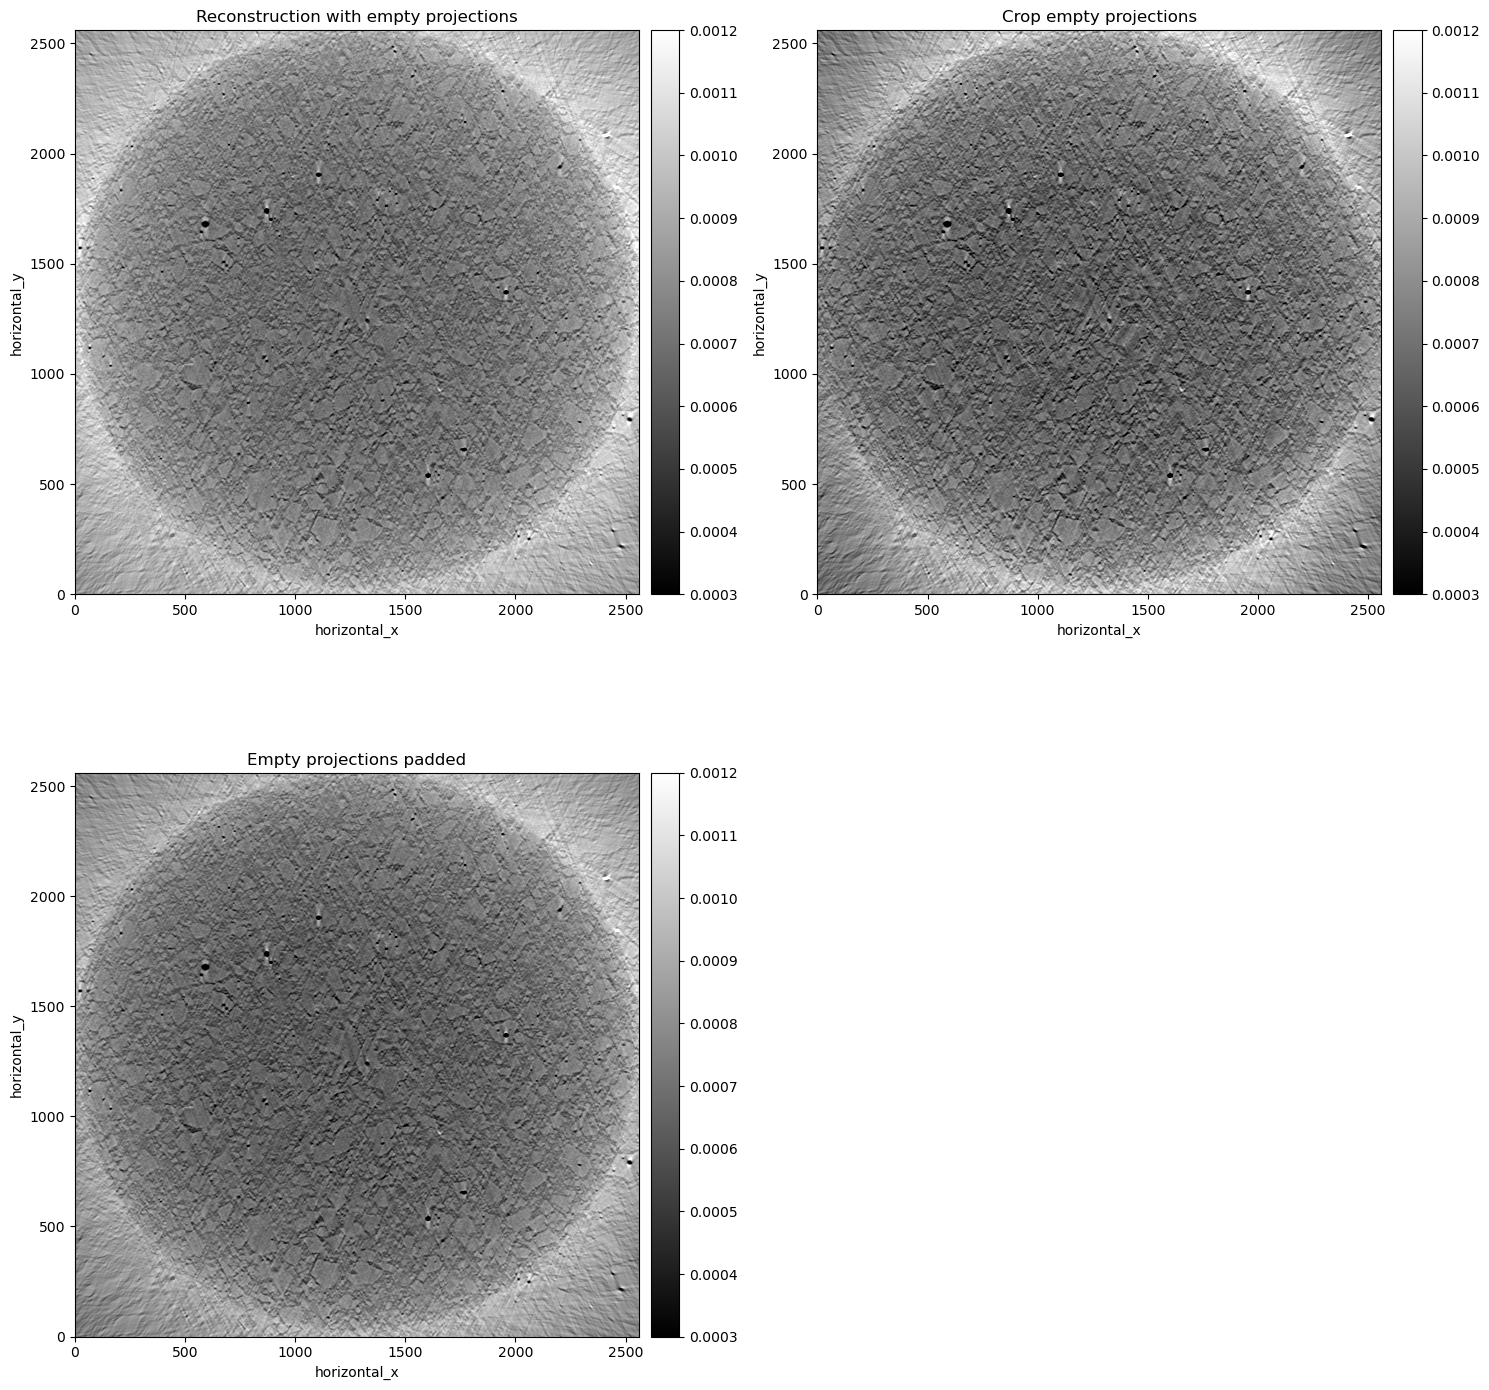

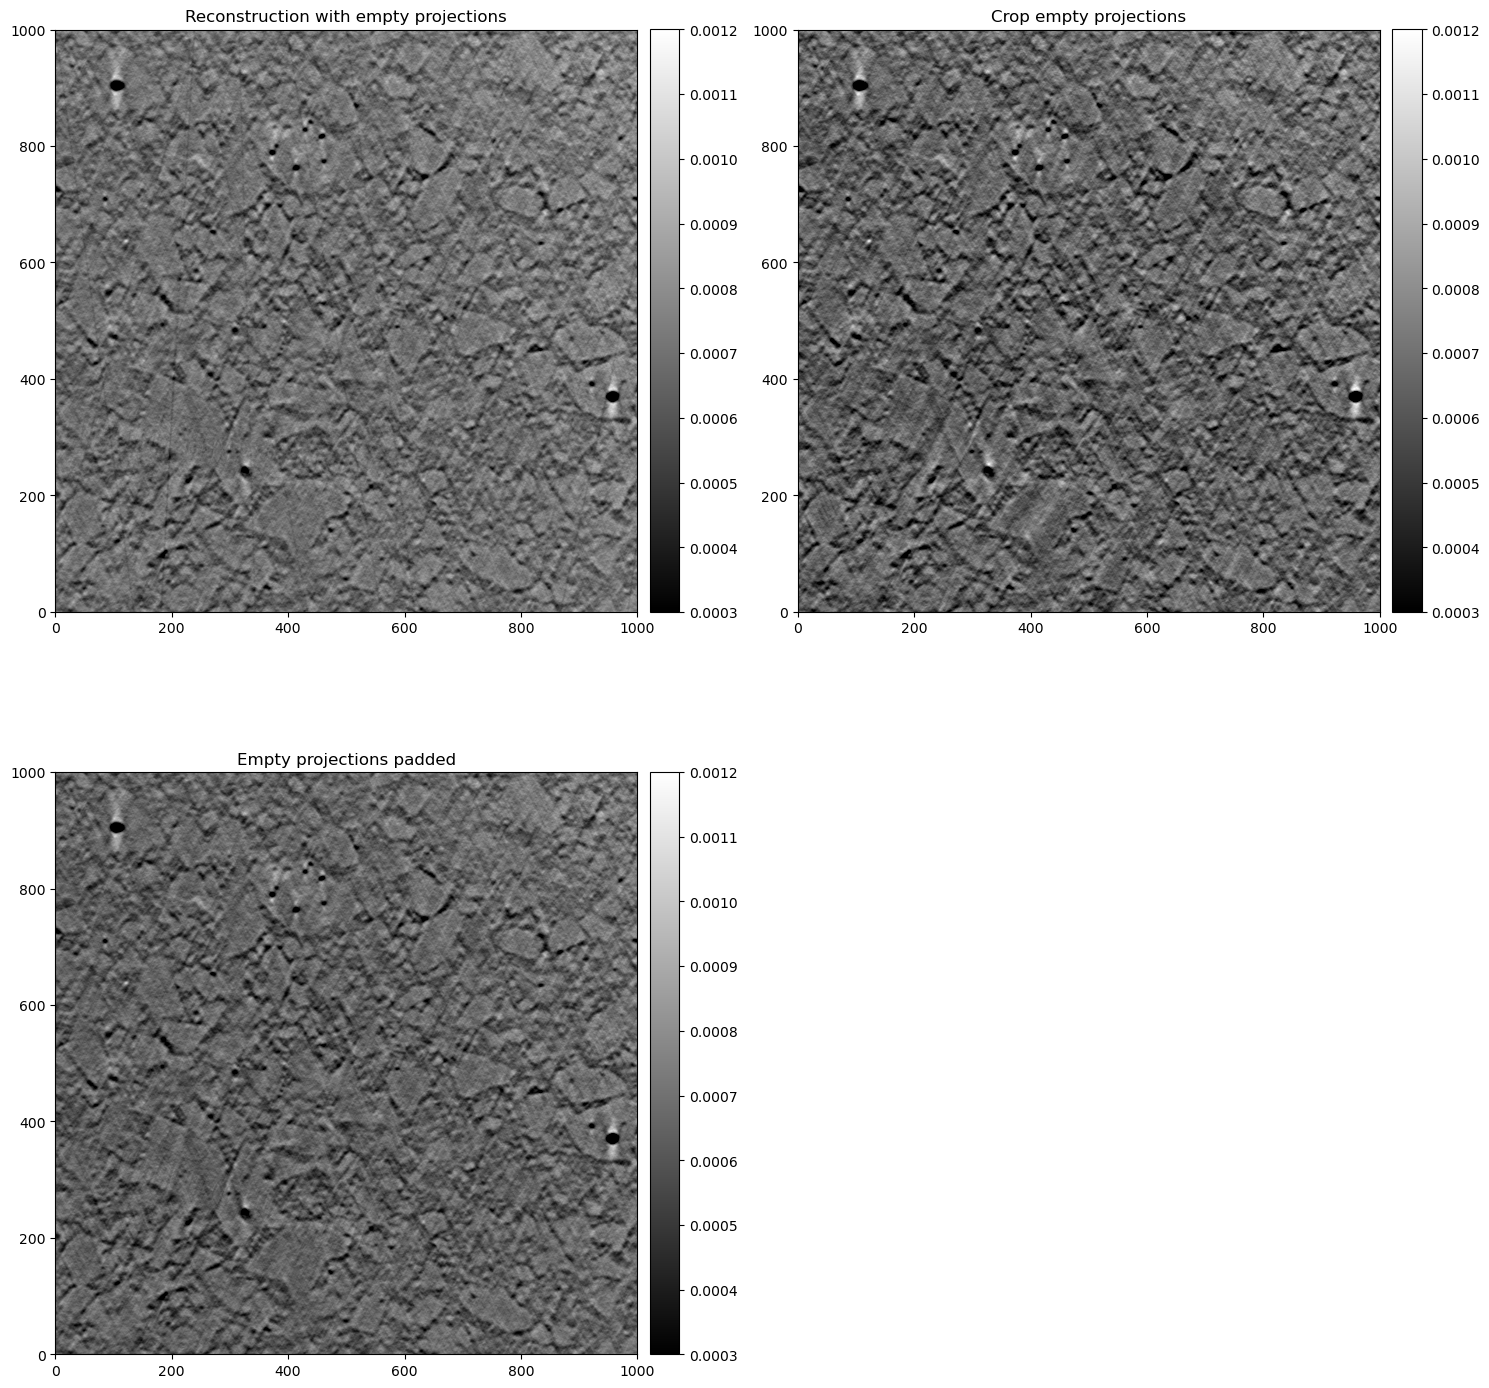

In [11]:

show2D([reco, reco_crop, reco_fill], ['Reconstruction with empty projections', 'Crop empty projections', 'Empty projections padded'], fix_range=(0.0003, 0.0012))
show2D([reco.array[1000:2000,1000:2000], reco_crop.array[1000:2000,1000:2000], reco_fill.array[1000:2000,1000:2000]], ['Reconstruction with empty projections', 'Crop empty projections', 'Empty projections padded'], fix_range=(0.0003, 0.0012))
# show2D(reco_FBP.array[1000:2000,1000:2000]-reco_FBP_uncropped.array[1000:2000,1000:2000], 'Diff')

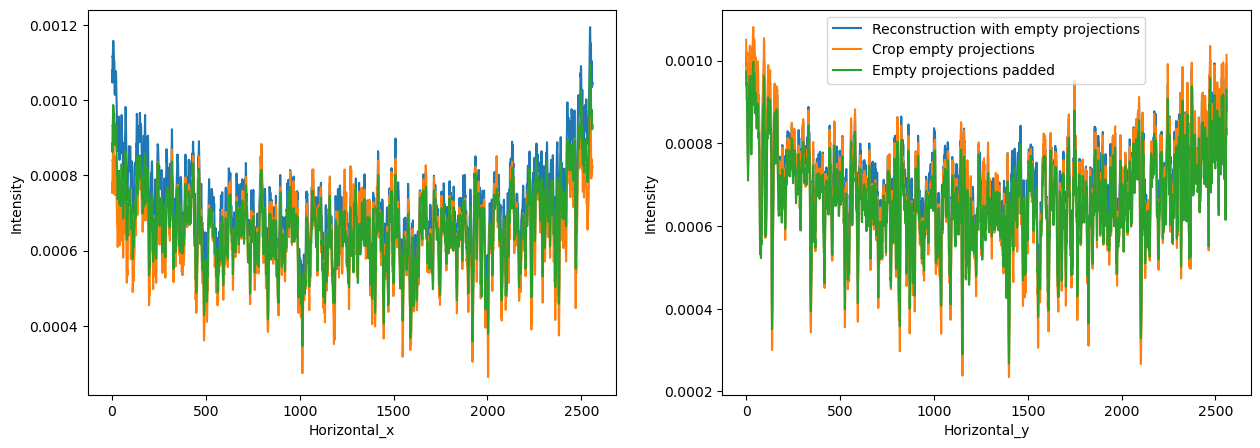

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax = axs[0]
ax.plot(reco.array[int(reco.shape[0]/2),:])
ax.plot(reco_crop.array[int(reco_crop.shape[0]/2),:])
ax.plot(reco_fill.array[int(reco_crop.shape[0]/2),:])
ax.set_xlabel('Horizontal_x')
ax.set_ylabel('Intensity')
ax = axs[1]
ax.plot(reco.array[:,int(reco.shape[1]/2)])
ax.plot(reco_crop.array[:,int(reco_crop.shape[1]/2)])
ax.plot(reco_fill.array[:,int(reco_crop.shape[1]/2)])
ax.set_xlabel('Horizontal_y')
ax.set_ylabel('Intensity')
ax.legend(['Reconstruction with empty projections', 'Crop empty projections', 'Empty projections padded'])


Text(0.5, 0, 'Intensity')

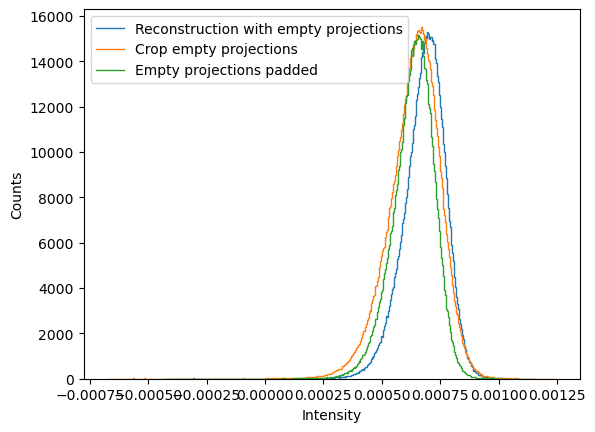

In [39]:
counts, bins = np.histogram(reco.array[1000:2000,1000:2000], bins=500)
plt.stairs(counts, bins)
counts, bins = np.histogram(reco_crop.array[1000:2000,1000:2000], bins=500)
plt.stairs(counts, bins)
counts, bins = np.histogram(reco_fill.array[1000:2000,1000:2000], bins=500)
plt.stairs(counts, bins)
plt.legend(['Reconstruction with empty projections', 'Crop empty projections', 'Empty projections padded'])
plt.ylabel('Counts')
plt.xlabel('Intensity')
